In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter
print('done all modules imported ')

done all modules imported 


In [2]:
#getting the file from google drive (test data)
import gdown

url = 'https://drive.google.com/uc?id=1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9'
output = 'train.csv'
# https://drive.google.com/file/d/1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9/view?usp=sharing
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9
To: /content/train.csv
201MB [00:01, 109MB/s] 


'train.csv'

In [3]:
#getting the data from google drive (resources data)resources data
import gdown
url = 'https://drive.google.com/uc?id=14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe'
output = 'resources.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe
To: /content/resources.csv
127MB [00:00, 136MB/s] 


'resources.csv'

In [0]:
dft = pd.read_csv('train.csv',nrows=50000)
dfr = pd.read_csv('resources.csv')

In [5]:
print("Number of data points in train data", dft.shape)
print('^^'*50)
print("The attributes of data :", dft.columns.values)
print('^^'*50)
print(dfr.shape)
print(dfr.columns.values)

Number of data points in train data (50000, 17)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(1541272, 4)
['id' 'description' 'quantity' 'price']


In [6]:
#sort the datapoints by date and time column
# list comprehension python : https://stackoverflow.com/a/2582163/4084039
# cols = ['Date' if x=='project_submitted_datetime' else x for x in list(dft.columns)]
# #sort dataframe based on time  uisng pandas to_datetime function  : https://stackoverflow.com/a/49702492/4084039
# dft['Date'] = pd.to_datetime(dft['project_submitted_datetime'])
# dft.drop('project_submitted_datetime', axis=1, inplace=True)# we drop the col
# dft.sort_values(by=['Date'], inplace=True)# sort the values y date
dft.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


## 1.1  Text preprocessing

In [0]:
# merge two column text dataframe: 
dft["essay"] = dft["project_essay_1"].map(str) +\
               dft["project_essay_2"].map(str) + \
               dft["project_essay_3"].map(str) + \
               dft["project_essay_4"].map(str)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list so as to get btter prediction : that is , no , not ,etc .
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

#### Preprocessing of the `**project_subject_categories**`

In [10]:
categories = list(dft['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in categories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())
    
dft['clean_categories'] = cat_list
dft.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in dft['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
project_subject_categories_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
print(project_subject_categories_dict)

{'Warmth': 643, 'Care_Hunger': 643, 'History_Civics': 2689, 'Music_Arts': 4699, 'AppliedLearning': 5569, 'SpecialNeeds': 6233, 'Health_Sports': 6538, 'Math_Science': 18874, 'Literacy_Language': 23998}


#### preprocessing of the `**project_subject_subcategories**`

In [11]:
sub_catogories = list(dft['project_subject_subcategories'].values)
# # remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# # https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# # https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split():
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

dft['clean_subcategories'] = sub_cat_list
dft.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in dft['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
project_subject_subcategories_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
project_subject_subcategories_dict

{'AppliedSciences': 4901,
 'Care_Hunger': 643,
 'CharacterEducation': 958,
 'Civics_Government': 380,
 'College_CareerPrep': 1168,
 'CommunityService': 214,
 'ESL': 1999,
 'EarlyDevelopment': 1937,
 'Economics': 127,
 'EnvironmentalScience': 2533,
 'Extracurricular': 373,
 'FinancialLiteracy': 253,
 'ForeignLanguages': 388,
 'Gym_Fitness': 2068,
 'Health_LifeScience': 1876,
 'Health_Wellness': 4732,
 'History_Geography': 1433,
 'Literacy': 15611,
 'Literature_Writing': 10127,
 'Mathematics': 12832,
 'Music': 1432,
 'NutritionEducation': 617,
 'Other': 1128,
 'ParentInvolvement': 302,
 'PerformingArts': 910,
 'SocialSciences': 864,
 'SpecialNeeds': 6233,
 'TeamSports': 995,
 'VisualArts': 2865,
 'Warmth': 643}

#### preprocessing of the `**project_grade_category**`

In [12]:
Grade= list(dft['project_grade_category'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

grade_cat_list = []
for i in Grade:
    # consider we have text like this:
    for j in i.split(' '): #    # split by spae
        j=j.replace('Grades','')# clean grades from the row
    grade_cat_list.append(j.strip())
    


dft['clean_grade'] = grade_cat_list 
dft.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in dft['clean_grade'].values:
    my_counter.update(word.split())
    
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))
sorted_project_grade_category_dict

{'3-5': 16968, '6-8': 7750, '9-12': 4966, 'PreK-2': 20316}

## Preparing data matrix for the models for Model

#### Spliting the Data for test , train and cv using the SKlearn Module train_test_split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dft,dft['project_is_approved'],stratify= dft['project_is_approved'],test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify= y_train,test_size = 0.33)

In [14]:
print("the shape of the Y_train data ", y_train.value_counts())
print("&"*25)
print("the shape of the Y_test data ",y_test.value_counts())
print("&"*25)
print("the shape of the Y_cv data ",y_cv.value_counts())
print("&"*25)
print("the above representaion shows a huge imbalance in data ")

the shape of the Y_train data  1    18982
0     3463
Name: project_is_approved, dtype: int64
&&&&&&&&&&&&&&&&&&&&&&&&&
the shape of the Y_test data  1    13954
0     2546
Name: project_is_approved, dtype: int64
&&&&&&&&&&&&&&&&&&&&&&&&&
the shape of the Y_cv data  1    9350
0    1705
Name: project_is_approved, dtype: int64
&&&&&&&&&&&&&&&&&&&&&&&&&
the above representaion shows a huge imbalance in data 


In [0]:
# Dropping the target variable coloums 
X_train.drop(["project_is_approved"], axis = 1, inplace = True) 
#x_test = 
X_test.drop(["project_is_approved"], axis = 1, inplace = True) 
#x_cv = 
X_cv.drop(["project_is_approved"], axis = 1, inplace = True) 


#### Pre-processing the Text Features ,
here we are independtenly doing the preprocessing as i observed that if we pre-processes and then divide the data , it is casuing in lower AUC score 

In [16]:
#Proprocessing of  essay for X_train
# https://gist.github.com/sebleier/554280 
from tqdm import tqdm
preprocessed_essays_train = []
for sentance in tqdm(X_train['essay'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed_essays_train.append(sent.lower().strip())

100%|██████████| 22445/22445 [00:11<00:00, 1916.23it/s]


In [17]:
#Proprocessing of  essay for X_test

from tqdm import tqdm
preprocessed_essays_test = []
for sentance in tqdm(X_test['essay'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed_essays_test.append(sent.lower().strip())

100%|██████████| 16500/16500 [00:08<00:00, 1935.72it/s]


In [18]:
#Proprocessing of  essay for X_CV

from tqdm import tqdm
preprocessed_essays_cv = []
for sentance in tqdm(X_cv['essay'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed_essays_cv.append(sent.lower().strip())

100%|██████████| 11055/11055 [00:05<00:00, 1923.50it/s]


In [19]:
# Proprocessing for project_title of preprocessed_titles_train

from tqdm import tqdm
preprocessed_titles_train = []
for sentance in tqdm(X_train['project_title'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed_titles_train.append(sent.lower().strip())

100%|██████████| 22445/22445 [00:00<00:00, 43499.23it/s]


In [20]:
# Proprocessing for project_title of preprocessed_titles_test
 
from tqdm import tqdm
preprocessed_titles_test = []
for sentance in tqdm(X_test['project_title'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
   # https://gist.github.com/sebleier/554280
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed_titles_test.append(sent.lower().strip())

100%|██████████| 16500/16500 [00:00<00:00, 44060.73it/s]


In [21]:
#Proprocessing for project_title of preprocessed_titles_cv

from tqdm import tqdm
preprocessed_titles_cv = []
for sentance in tqdm(X_cv['project_title'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed_titles_cv.append(sent.lower().strip())

100%|██████████| 11055/11055 [00:00<00:00, 42790.09it/s]


## 2.1 vectorizing the Categorical Data
The vectorizing Processes used here is One-hot Encoding 


In [22]:
from collections import Counter
my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
project_subject_categories_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
print(project_subject_categories_dict)

#  vectorizing Processes of clean_categories 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(vocabulary=list(project_subject_categories_dict.keys()), lowercase=False, binary=True)
vectorizer1.fit(X_train['clean_categories'].values)

# The fit is only to be happen on the train data orelse it may casue data leakage
# we use the fitted CountVectorizer on X_train data for converting the text to vector form (i.e using One- hot encoding )
X_train_cat = vectorizer1.transform(X_train['clean_categories'].values)
X_cv_cat = vectorizer1.transform(X_cv['clean_categories'].values)
X_test_cat = vectorizer1.transform(X_test['clean_categories'].values)

print(vectorizer1.get_feature_names())


{'Warmth': 289, 'Care_Hunger': 289, 'History_Civics': 1246, 'Music_Arts': 2103, 'AppliedLearning': 2485, 'SpecialNeeds': 2837, 'Health_Sports': 2910, 'Math_Science': 8488, 'Literacy_Language': 10706}
['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


In [23]:
print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_cat.shape, y_train.shape)
print("="*100)
print(X_cv_cat.shape, y_cv.shape)
print("="*100)
print(X_test_cat.shape, y_test.shape)

After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)


In [24]:
# The fit is only to be happen on the train data orelse it may casue data leakage
# we use the fitted CountVectorizer on X_train data for converting the text to vector form (i.e using One- hot encoding )
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(vocabulary=list(project_subject_subcategories_dict.keys()), lowercase=False, binary=True)
vectorizer2.fit(X_train['clean_subcategories'].values)


X_train_subcat = vectorizer2.transform(X_train['clean_subcategories'].values)
X_cv_subcat = vectorizer2.transform(X_cv['clean_subcategories'].values)
X_test_subcat = vectorizer2.transform(X_test['clean_subcategories'].values)

print(vectorizer2.get_feature_names())

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [25]:
print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_subcat.shape, y_train.shape)
print("="*100)
print(X_cv_subcat.shape, y_cv.shape)
print("="*100)
print(X_test_subcat.shape, y_test.shape)


After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)


In [26]:
#school_state data column convert categorical to vectors
# 1st the vocabulary of the words are taken into account then it is used to do one - hot - encodng 
# then sort the dictonary and apply the one - hot - encoding 
from collections import Counter
my_counter = Counter()
for word in dft['school_state'].values:
    my_counter.update(word.split())

school_state_dict = dict(my_counter)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

# here the data is converted into ector form 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer3.fit(dft['school_state'].values)


X_train_school_state = vectorizer3.transform(X_train['school_state'].values)
X_cv_school_state = vectorizer3.transform(X_cv['school_state'].values)
X_test_school_state = vectorizer3.transform(X_test['school_state'].values)

print(vectorizer3.get_feature_names())

['VT', 'WY', 'ND', 'MT', 'RI', 'NH', 'SD', 'NE', 'AK', 'DE', 'WV', 'ME', 'NM', 'HI', 'DC', 'KS', 'ID', 'IA', 'AR', 'CO', 'MN', 'OR', 'MS', 'KY', 'NV', 'MD', 'CT', 'TN', 'AL', 'UT', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'MA', 'LA', 'WA', 'MO', 'IN', 'OH', 'PA', 'MI', 'GA', 'SC', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']


In [27]:
print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_school_state .shape, y_train.shape)
print(X_cv_school_state .shape, y_cv.shape)
print(X_test_school_state .shape, y_test.shape)


After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)


In [28]:
# here i am converting the clean_grade into vectors 
#Fillna is used to fill all he spaces that are present in the data coloumn
#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
dft['clean_grade']=dft['clean_grade'].fillna("")# fill the nulll values with space

## here i am using the data from the unsplitted data as there as small number of values and may not present in the X_train data
#  so i am fitting it withe original data then converting into vectors 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer4 = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer4.fit(dft['clean_grade'].values)

# firstly convert fit the train data into the vectoriaer then it learn hte vocablery

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category = vectorizer4.transform(X_train['clean_grade'].values)
X_cv_project_grade_category = vectorizer4.transform(X_cv['clean_grade'].values)
X_test_project_grade_category = vectorizer4.transform(X_test['clean_grade'].values)

print(vectorizer4.get_feature_names())

['9-12', '6-8', '3-5', 'PreK-2']


In [29]:
print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_project_grade_category  .shape, y_train.shape)
print(X_cv_project_grade_category  .shape, y_cv.shape)
print(X_test_project_grade_category  .shape, y_test.shape)


After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)


In [30]:
##https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
dft['teacher_prefix']=dft['teacher_prefix'].fillna(" ")# filll the null values with space
my_counter = Counter()
for word in dft['teacher_prefix'].values:
    my_counter.update(word.split())
    
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
teacher_cat_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_cat_dict.items(), key=lambda kv: kv[1]))
## here i am using the data from the unsplitted data as there as small number of values and may not present in the X_train data
#  so i am fitting it withe original data then converting into vectors 
# after counting the frequency of the words we then transform into vectors 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer5 = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False, binary=True)
vectorizer5.fit(dft['teacher_prefix'].values.astype('U'))

#  the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix = vectorizer5.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_prefix= vectorizer5.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_prefix = vectorizer5.transform(X_test['teacher_prefix'].values.astype('U'))

print(vectorizer5.get_feature_names())


# when i executeed this error comes
#np.nan is an invalid document, expected byte or unicode string.
# then iconvert to unicode just write .astype('U') after the .values in fit and transform
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']


In [31]:
print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_teacher_prefix.shape, y_train.shape)
print(X_cv_teacher_prefix.shape, y_cv.shape)
print(X_test_teacher_prefix.shape, y_test.shape)
print("="*100)

After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)


## 3.1 BOW Vectorization of the data : Processed essay and Project titles

In [0]:
# i am assigning the values of diffrent preprocessing to avoid confusion 
# Changing the termonilogy 
X_train_essay=preprocessed_essays_train
X_cv_essay=preprocessed_essays_cv
X_test_essay=preprocessed_essays_test

In [33]:
vectorizer6 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
# here i am using the DF to be 10 and max features to be 5000 and uni and bi grams , refrence given below
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer6.fit(X_train_essay)

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer6.transform(X_train_essay)
X_cv_bow = vectorizer6.transform(X_cv_essay)
X_test_bow = vectorizer6.transform(X_test_essay)

print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("so the dimension of all are the same and there will be no data leakage") 
# print(vectorizer6.get_feature_names())

After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)
so the dimension of all are the same and there will be no data leakage


In [0]:
# i am assigning the values of diffrent preprocessing to avoid confusion 
# Changing the termonilogy 
X_train_title=preprocessed_titles_train
X_cv_title=preprocessed_titles_cv
X_test_title=preprocessed_titles_test

In [35]:
# Project title BOW
vectorizer7 = CountVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer7.fit(X_train_title)
# here i am using the DF to be 10 and max features to be 5000 and uni and bi grams , refrence given below
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
X_train_bow_title = vectorizer7.transform(X_train_title)
X_cv_bow_title= vectorizer7.transform(X_cv_title)
X_test_bow_title = vectorizer7.transform(X_test_title)

print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_bow_title.shape, y_train.shape)
print(X_cv_bow_title.shape, y_cv.shape)
print(X_test_bow_title.shape, y_test.shape)
print("so the dimension of all are the same and there will be no data leakage") 


After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 1619) (22445,)
(11055, 1619) (11055,)
(16500, 1619) (16500,)
so the dimension of all are the same and there will be no data leakage


## 3.2 TFIDF Vectorization of the data : Processed essay and Project titles

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents and max of 5000 features .
vectorizer8 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer8.fit(X_train_title)# that is learned from trainned  data


# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_title = vectorizer8.transform(X_train_title)
X_cv_tf_title= vectorizer8.transform(X_cv_title)
X_test_tf_title = vectorizer8.transform(X_test_title)

print("After vectorizations the shape of the data changes : it would be a spare matix form")
print(X_train_tf_title.shape, y_train.shape)
print(X_cv_tf_title.shape, y_cv.shape)
print(X_test_tf_title.shape, y_test.shape)
print("so the dimension of all are the same and there will be no data leakage") 

After vectorizations the shape of the data changes : it would be a spare matix form
(22445, 1619) (22445,)
(11055, 1619) (11055,)
(16500, 1619) (16500,)
so the dimension of all are the same and there will be no data leakage


In [37]:
#for essay
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer9 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))# its a countvectors used for convert text to vectors
vectorizer9.fit(X_train_essay)# that is learned from trainned  data



# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_essay = vectorizer9.transform(X_train_essay)
X_cv_tf_essay= vectorizer9.transform(X_cv_essay)
X_test_tf_essay = vectorizer9.transform(X_test_essay)



print("After vectorizations")
print(X_train_tf_essay.shape, y_train.shape)
print(X_cv_tf_essay.shape, y_cv.shape)
print(X_test_tf_essay.shape, y_test.shape)
print("="*100)
# so the dimension of alll are the same by using first fit and then transform


After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


## 3.3 AVG W2V Vectorization of the data : Processed essay and Project titles

In [38]:
import gdown

url = 'https://drive.google.com/uc?id=1MqUasf7jYoPbG35MJ28VQcOjjNp-ZDDp'
output = 'glove_vectors'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1MqUasf7jYoPbG35MJ28VQcOjjNp-ZDDp
To: /content/glove_vectors
128MB [00:02, 63.3MB/s]


'glove_vectors'

In [0]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
def AVG_W2V(values):
# AVG W2V Vectorization. 

  train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length    # we are taking the 300 dimensions  very large
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_vectors.append(vector)

  print(len(train_avg_w2v_vectors))
  print(len(train_avg_w2v_vectors[0]))
  return train_avg_w2v_vectors


In [41]:
train_avg_w2v_vectors=AVG_W2V(preprocessed_essays_train)
test_avg_w2v_vectors=AVG_W2V(preprocessed_essays_test)
cv_avg_w2v_vectors=AVG_W2V(preprocessed_essays_cv)

  2%|▏         | 363/16500 [00:00<00:04, 3627.11it/s]

22445
300


  3%|▎         | 382/11055 [00:00<00:02, 3810.13it/s]

16500
300


100%|██████████| 11055/11055 [00:02<00:00, 3764.67it/s]

11055
300


In [42]:
#  AVG W2V for preprocessed_titles
train_avg_w2v_vectors_title=AVG_W2V(preprocessed_titles_train)
test_avg_w2v_vectors_title=AVG_W2V(preprocessed_titles_test)
cv_avg_w2v_vectors_title=AVG_W2V(preprocessed_titles_cv)


 41%|████      | 6771/16500 [00:00<00:00, 67703.77it/s]

22445
300


100%|██████████| 11055/11055 [00:00<00:00, 65830.20it/s]

16500
300
11055
300


### 3.4 TFIDF weighted W2V vectorization using the Pretrained Models

In [0]:
#here i am converting the dictionary with word as a key, and the idf as a value for the vectorization processes 
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def tf_idf_done(word_list):
  
  train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(word_list): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():#.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_title_tfidf_w2v_vectors.append(vector)

  print(len(train_title_tfidf_w2v_vectors))
  print(len(train_title_tfidf_w2v_vectors[0]))
  return train_title_tfidf_w2v_vectors

In [45]:
# Vectorization the Processed titles 
train_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_train)
test_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_test)
cv_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_cv)

 23%|██▎       | 3765/16500 [00:00<00:00, 37645.91it/s]

22445
300


 33%|███▎      | 3682/11055 [00:00<00:00, 36810.82it/s]

16500
300


100%|██████████| 11055/11055 [00:00<00:00, 35964.09it/s]

11055
300


In [46]:
# Vectrozation of the preprocessed_essays
train_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_train)
test_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_test)
cv_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_cv)

  0%|          | 59/16500 [00:00<00:28, 579.82it/s]

22445
300


  1%|          | 59/11055 [00:00<00:18, 583.36it/s]

16500
300


100%|██████████| 11055/11055 [00:18<00:00, 597.67it/s]

11055
300


### 4. 1 Vectorization of the  Numerical features 


In [47]:
#  there are 2 numerical features in the Resources data.csv so have to merge th dataframes 
price_data = dfr.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
dft = pd.merge(dft, price_data, on='id', how='left')
print(price_data.head(7))

# same has to be done foe the train and test data 
X_train = pd.merge(X_train, price_data, on = "id", how = "left")
X_test = pd.merge(X_test, price_data, on = "id", how = "left")
X_cv = pd.merge(X_cv, price_data, on = "id", how = "left")

        id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8
5  p000006   130.62         5
6  p000007   157.98         6


In [0]:
from sklearn.preprocessing import StandardScaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scalar =  StandardScaler()
scalar.fit(X_train['price'].values.reshape(-1,1))

train_price_standar = scalar.transform(X_train['price'].values.reshape(-1, 1))
test_price_standar = scalar.transform(X_test['price'].values.reshape(-1, 1))
cv_price_standar = scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [0]:
scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
train_prev_proj_standar = scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
test_prev_proj_standar = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
cv_prev_proj_standar = scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))



In [0]:
scalar.fit(X_train['quantity'].values.reshape(-1,1))
train_qnty_standar = scalar.transform(X_train['quantity'].values.reshape(-1, 1))
cv_qnty_standar = scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
test_qnty_standar = scalar.transform(X_test['quantity'].values.reshape(-1, 1))


### **Mergaing of all the Data matrix for diffrent sets of opeations **

1.   Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (`BOW with bi-grams` with `min_df=10` and max_features=5000`)
2.   Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (`TFIDF with bi-grams` with `min_df=10` and `max_features=5000`)
3.   Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)
4.   Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)




Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW with bi-grams with min_df=10 and max_features=5000`)

In [51]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set1_train = hstack((X_train_bow_title,X_train_bow,X_train_teacher_prefix,X_train_cat,X_train_subcat ,X_train_project_grade_category,\
                       X_train_school_state,train_qnty_standar,train_price_standar,train_prev_proj_standar))
# printing the shape of X_set1_train data metrix
print(" printing the shape of X_set1_train data metrix",X_set1_train.shape, y_train.shape)

X_set1_cv = hstack((X_cv_bow_title,X_cv_bow,X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,X_cv_project_grade_category,X_cv_school_state,\
                    cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))
# printing the shape of X_set1_cv data metrix 
print("printing the shape of X_set1_cv data metrix",X_set1_cv.shape, y_cv.shape)

X_set1_test = hstack((X_test_bow_title,X_test_bow,X_test_teacher_prefix,X_test_cat,X_test_subcat,X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar))

# printing the shape of X_set1_test data metrix 
print("printing the shape of X_set1_test data metrix ",X_set1_test.shape, y_test.shape)


 printing the shape of X_set1_train data metrix (22445, 6721) (22445,)
printing the shape of X_set1_cv data metrix (11055, 6721) (11055,)
printing the shape of X_set1_test data metrix  (16500, 6721) (16500,)


Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF with bi-grams with min_df=10 and max_features=5000)

In [52]:
X_set2_train = hstack((X_train_tf_essay,X_train_tf_title,X_train_teacher_prefix,X_train_cat,X_train_subcat,X_train_project_grade_category,X_train_school_state,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))


print("printing the shape of X_set2_train data metrix",X_set2_train.shape, y_train.shape)

print("*"*50)
X_set2_cv = hstack((X_cv_tf_essay,X_cv_tf_title,X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,X_cv_project_grade_category,X_cv_school_state,
                   cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))

print("printing the shape of X_set2_cv data metrix",X_set2_cv.shape, y_cv.shape)

print("*"*50)
X_set2_test = hstack((X_test_tf_essay,X_test_tf_title,X_test_teacher_prefix,X_test_cat,X_test_subcat, X_test_project_grade_category,X_test_school_state,
                     test_qnty_standar,test_price_standar,test_prev_proj_standar))

print("printing the shape of X_set2_test data metrix",X_set2_test.shape, y_test.shape)



printing the shape of X_set2_train data metrix (22445, 6721) (22445,)
**************************************************
printing the shape of X_set2_cv data metrix (11055, 6721) (11055,)
**************************************************
printing the shape of X_set2_test data metrix (16500, 6721) (16500,)


Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

In [53]:
X_set3_train = hstack((train_avg_w2v_vectors,train_avg_w2v_vectors_title,train_prev_proj_standar,train_price_standar,train_qnty_standar,
                      X_train_teacher_prefix,X_train_cat,X_train_subcat,
                      X_train_project_grade_category,X_train_school_state))


print("printing the shape of X_set3_train data metrix",X_set3_train.shape, y_train.shape)
print("*"*50)

X_set3_cv = hstack((cv_avg_w2v_vectors,cv_avg_w2v_vectors_title,cv_prev_proj_standar,cv_price_standar,cv_qnty_standar,
                      X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                      X_cv_project_grade_category,X_cv_school_state))


print("printing the shape of X_set3_cv data metrix",X_set3_cv.shape, y_cv.shape)
print("*"*50)

X_set3_test = hstack((test_avg_w2v_vectors,test_avg_w2v_vectors_title,test_prev_proj_standar,test_price_standar,test_qnty_standar,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state))


print("printing the shape of X_set3_test data metrix",X_set3_test.shape, y_test.shape)



printing the shape of X_set3_train data metrix (22445, 702) (22445,)
**************************************************
printing the shape of X_set3_cv data metrix (11055, 702) (11055,)
**************************************************
printing the shape of X_set3_test data metrix (16500, 702) (16500,)


Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)

In [54]:
X_set4_train = hstack((train_tfidf_w2v_vectors,train_title_tfidf_w2v_vectors,train_prev_proj_standar,train_price_standar,train_qnty_standar,
                      X_train_teacher_prefix,X_train_cat,X_train_subcat,
                      X_train_project_grade_category,X_train_school_state))


print("printing the shape of X_set4_train data metrix",X_set4_train.shape, y_train.shape)
print("*"*50)

X_set4_cv = hstack((cv_tfidf_w2v_vectors,cv_title_tfidf_w2v_vectors,cv_prev_proj_standar,cv_price_standar,cv_qnty_standar,
                      X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                      X_cv_project_grade_category,X_cv_school_state))


print("printing the shape of X_set4_CV data metrix",X_set4_cv.shape, y_cv.shape)

print("*"*50)
X_set4_test = hstack((test_title_tfidf_w2v_vectors,test_tfidf_w2v_vectors,test_prev_proj_standar,test_price_standar,test_qnty_standar,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state))


print("printing the shape of X_set4_test data metrix",X_set4_test.shape, y_test.shape)

printing the shape of X_set4_train data metrix (22445, 702) (22445,)
**************************************************
printing the shape of X_set4_CV data metrix (11055, 702) (11055,)
**************************************************
printing the shape of X_set4_test data metrix (16500, 702) (16500,)


### Applying the Logistic Regression model  on SET:1

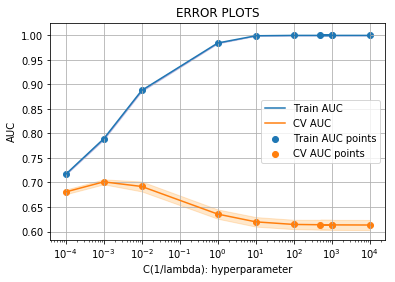

In [55]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV


clf = LogisticRegression(class_weight='balanced');
parameters ={'C':[10**-4, 10**-3,10**-2,1,10,100,1000,500,1000,10000]}
sd=GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(X_set1_train, y_train);


train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc = sd.cv_results_['mean_test_score'] 
cv_auc_std= sd.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("C(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

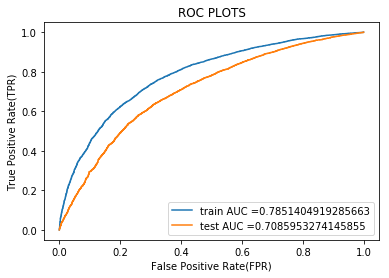

In [56]:
##Fitting Model to Hyper-Parameter Curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = LogisticRegression(C=10**-3,class_weight='balanced');
neigh.fit(X_set1_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_set1_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_set1_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()

The Confusion metrix for Train data 


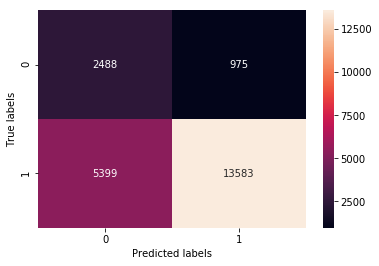

In [57]:
# Heat map representaion of the Confusion metrix 
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_set1_train )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
print("The Confusion metrix for Train data ")

The Confusion metrix for Test data 


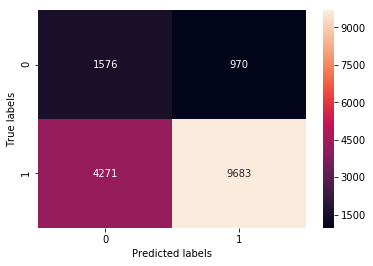

In [58]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_set1_test )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
print("The Confusion metrix for Test data ")

### Applying the Logistic Regression model  on SET:2

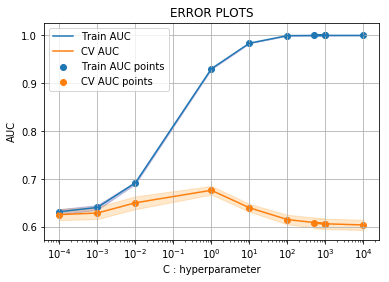

In [59]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV

clf = LogisticRegression(class_weight='balanced');
parameters ={'C':[10**-4, 10**-3,10**-2,1,10,100,1000,500,1000,10000]}
sd = GridSearchCV(clf, parameters, cv=3, scoring='roc_auc',return_train_score=True)
sd.fit(X_set2_train, y_train);

train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc =sd.cv_results_['mean_test_score'] 
cv_auc_std=sd.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

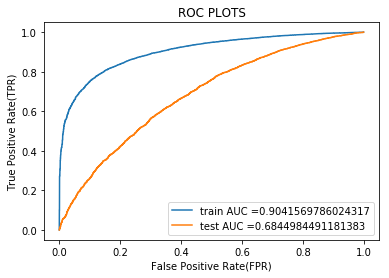

In [60]:
#Fitting Model to Hyper-Parameter Curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = LogisticRegression(C=1,class_weight='balanced');
neigh.fit(X_set2_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_set2_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_set2_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()


The Confusion metrix for Train data 


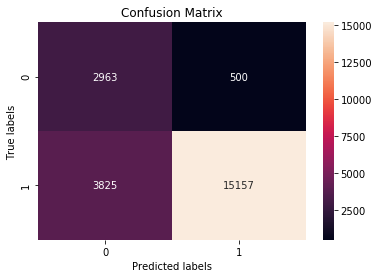

In [61]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_set2_train )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
print("The Confusion metrix for Train data ")

The Confusion metrix for Test data 


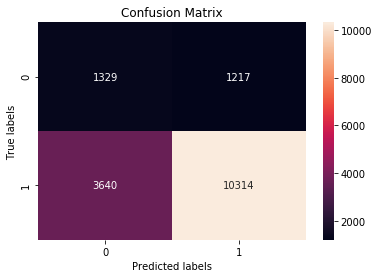

In [62]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_set2_test )), annot=True, ax = ax,fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
print("The Confusion metrix for Test data ")

### Applying the Logistic Regression model  on SET:3
Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

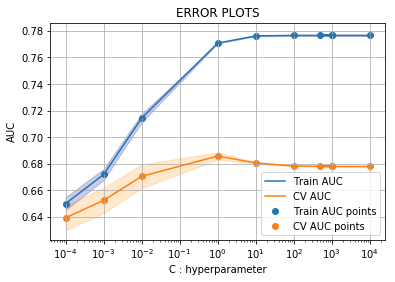

In [63]:
clf = LogisticRegression(class_weight='balanced');
parameters ={'C':[10**-4, 10**-3,10**-2,1,10,100,1000,500,1000,10000]}
cl = GridSearchCV(clf , parameters, cv=3, scoring='roc_auc',return_train_score=True)
cl.fit(X_set3_train, y_train);

train_auc= cl.cv_results_['mean_train_score']
train_auc_std= cl.cv_results_['std_train_score']
cv_auc = cl.cv_results_['mean_test_score'] 
cv_auc_std= cl.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

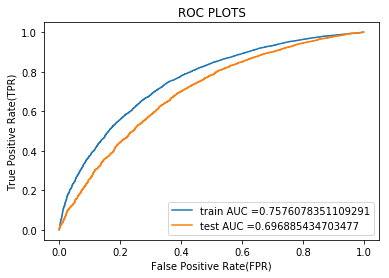

In [64]:
#Fitting Model to Hyper-Parameter Curve:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = LogisticRegression(C=1,class_weight='balanced');
neigh.fit(X_set3_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_set3_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_set3_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()
print("="*100)

The Confusion metrix for Train data 


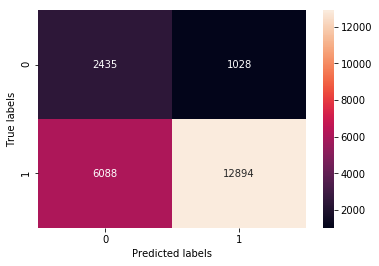

In [65]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_set3_train )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
print("The Confusion metrix for Train data ")

The Confusion metrix for Test data 


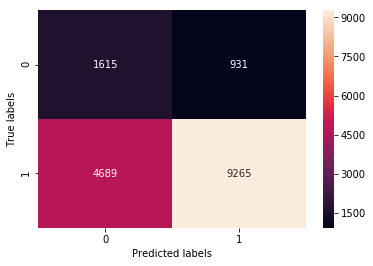

In [66]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_set3_test )), annot=True, ax = ax,fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
print("The Confusion metrix for Test data ")

### Applying the Logistic Regression model  on SET:4
categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)

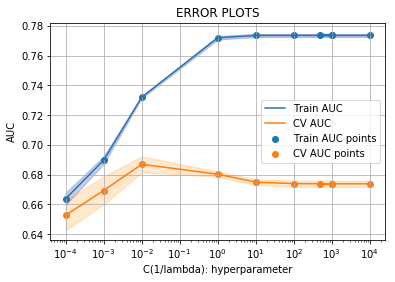

In [67]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

clf = LogisticRegression(class_weight='balanced');
parameters ={'C':[10**-4, 10**-3,10**-2,1,10,100,1000,500,1000,10000]}
cl = GridSearchCV(clf, parameters, cv=3, scoring='roc_auc',return_train_score=True)
cl.fit(X_set4_train, y_train);

train_auc= cl.cv_results_['mean_train_score']
train_auc_std= cl.cv_results_['std_train_score']
cv_auc = cl.cv_results_['mean_test_score'] 
cv_auc_std= cl.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("C(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

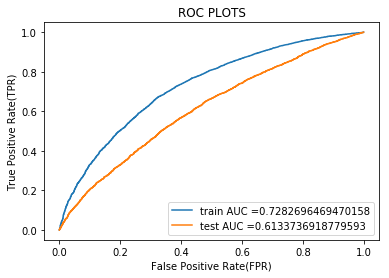

In [68]:
#Fitting Model to Hyper-Parameter Curve:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = LogisticRegression(C=10**-2,class_weight='balanced')
neigh.fit(X_set4_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_set4_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_set4_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

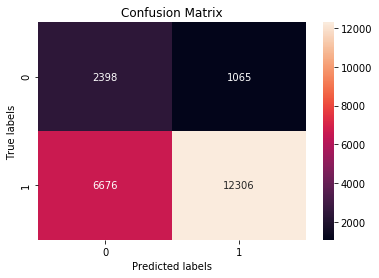

In [69]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_set4_train )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

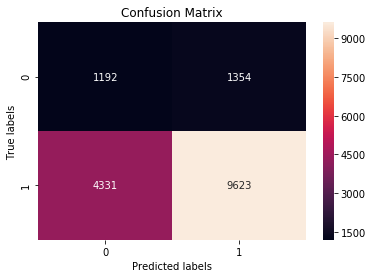

In [70]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_set4_test )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

### Logistic Regression on SET:5 


1.   school_state : categorical data
2.   clean_categories : categorical data
3.   clean_subcategories : categorical data
4.   project_grade_category :categorical data
5.   teacher_prefix : categorical data
6.   quantity : numerical data
7.   teacher_number_of_previously_posted_projects : numerical data
8.   price : numerical data
9.   sentiment score's of each of the essay : numerical data
10.  number of words in the title : numerical data
11.  number of words in the combine essays : numerical data


**Counting the Number of words and their length in project_title**
 

1.   number of words in the title : numerical data ,This is a new numerical feature that is Custom formed 






In [0]:
# Counting the Number of words and their length "project_title"
# in here we are looping inside every title and then spliting it then applyin the split to calculate the length.
# if we dont apply the split then every words length will be counted 
# For train data
# https://www.geeksforgeeks.org/python-string-split/
# https://www.jquery-az.com/5-examples-get-python-list-length-array-tuple-dictionary-also/
title_length_train=[]
for i in range(0,22445):
  title_length_train.append(len(X_train["project_title"][i].split()))
 
title_length_train=np.array(title_length_train)

#for test data titles
title_length_test=[]
for i in range(0,16500):
  title_length_test.append(len(X_test["project_title"][i].split()))
  
title_length_test=np.array(title_length_test)

#for cv data titles
title_length_cv=[]
for i in range(0,11055):
  title_length_cv.append(len(X_cv["project_title"][i].split()))
  
title_length_cv=np.array(title_length_cv)

**Counting the Number of words and their length in project_Essay**
 

1.   Number of words in the essay : numerical data ,This is a new numerical feature that is Custom formed 



In [0]:
#for test data esssay
essay_length_test=[]
for i in range(0,16500):
  essay_length_test.append(len(X_test["essay"][i].split()))
  
essay_length_test=np.array(essay_length_test)

#for cv data essay

essay_length_cv=[]
for i in range(0,11055):
  essay_length_cv.append(len(X_cv["essay"][i].split()))
  
essay_length_cv=np.array(essay_length_cv)


#for train data essay

essay_length_train=[]
for i in range(0,22445):
  essay_length_train.append(len(X_train["essay"][i].split()))
  
essay_length_train=np.array(essay_length_train)


**Sentiment score's of each of the essay : Numerical data**
in here i am adding a new feture that is the sentimental scores of the of the Processed essay 

In [73]:
"""
The code is taken from 
https://www.nltk.org/_modules/nltk/sentiment/vader.html
https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer
https://www.nltk.org/api/nltk.sentiment.html

VADER sentiment analysis tools:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
"""
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# this code is taken from 
# Project: seinfeld-analysis   Author: christopherjenness   File: analysis.py    (license) View Source Project
# https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer
#https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer
def Sentiment_Analyser(df):
    sentiments = []
    sid = SentimentIntensityAnalyzer()
    for i in range(df.shape[0]):
        line = df['essay'][i]# take one essay
        sentiment = sid.polarity_scores(line)# calculate the sentiment
        sentiments.append([sentiment['neg'], sentiment['pos'],
                           sentiment['neu'], sentiment['compound']])# list of lists
    df[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(sentiments)
    df['Negative'] = df['compound'] < -0.1
    df['Positive'] = df['compound'] > 0.1
    return df 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
X_train=Sentiment_Analyser(X_train)
X_test=Sentiment_Analyser(X_test)
X_cv=Sentiment_Analyser(X_cv)

In [75]:
X_train.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,essay,clean_categories,clean_subcategories,clean_grade,price,quantity,neg,pos,neu,compound,Negative,Positive
0,160434,p197727,7c3c08abf49160c18d75042ec10b5a7b,Ms.,CA,2017-02-12 15:39:26,Exploring Tech with Future Computer Scientists,My diverse set of students all have a huge dri...,My computer science students are more than eag...,NaN,NaN,My students need tech materials to further the...,2,My diverse set of students all have a huge dri...,Math_Science,AppliedSciences,9-12,419.54,5,0.007,0.183,0.810,0.9944,False,True
1,63298,p115545,6688982be792765f60708f4d382df67d,Mrs.,LA,2016-07-19 19:04:02,Teaching With Technology,My students are very eager five and six year o...,Students need access to technology they can us...,NaN,NaN,My students need the Samsung tablets to give t...,0,My students are very eager five and six year o...,AppliedLearning Literacy_Language,EarlyDevelopment Literacy,PreK-2,119.99,4,0.040,0.093,0.867,0.9682,False,True
2,130392,p224005,c0915a679827cda277fa86f2e7fef13f,Mrs.,AL,2017-02-22 13:22:59,Chrome Books in the Classroom,"My 1st graders are strong, kind, loving, helpf...",Our school has recently adopted a new online l...,NaN,NaN,My students need this chrome book so they can ...,1,"My 1st graders are strong, kind, loving, helpf...",Literacy_Language,Literacy,PreK-2,167.02,1,0.000,0.248,0.752,0.9969,False,True


In [76]:
#for train

poitive=list(X_train['pos'])
poitive=np.array(poitive)  #Converting into a numpy array 

negative=list(X_train['neg'])
negative=np.array(negative)

compound=list(X_train['compound'])
compound=np.array(compound)

# combine all
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set5_train = hstack((X_train_teacher_prefix,X_train_cat,X_train_subcat ,X_train_project_grade_category,X_train_school_state,
                      train_qnty_standar,train_price_standar,train_prev_proj_standar,
                      essay_length_train.reshape(-1,1),title_length_train.reshape(-1,1),
                      poitive.reshape(-1,1),negative.reshape(-1,1),compound.reshape(-1,1)))


print(X_set5_train.shape, y_train.shape)

(22445, 107) (22445,)


In [77]:
# here i am getting the X_CV of the poitive,negative,compound Sentiment scores 

poitive=list(X_cv['pos'])
poitive=np.array(poitive)

negative=list(X_cv['neg'])
negative=np.array(negative)

compound=list(X_cv['compound'])
compound=np.array(compound)

# combine all
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set5_cv = hstack((
                      X_cv_teacher_prefix,X_cv_cat,X_cv_subcat ,X_cv_project_grade_category,X_cv_school_state,
                      cv_qnty_standar,cv_price_standar,cv_prev_proj_standar,
                      essay_length_cv.reshape(-1,1),title_length_cv.reshape(-1,1),
                      poitive.reshape(-1,1),negative.reshape(-1,1),compound.reshape(-1,1)))


print(X_set5_cv.shape, y_cv.shape)

(11055, 107) (11055,)


In [78]:
#for test
poitive=list(X_test['pos'])
poitive=np.array(poitive)

negative=list(X_test['neg'])
negative=np.array(negative)

compound=list(X_test['compound'])
compound=np.array(compound)

# combine all
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set5_test = hstack((
                      X_test_teacher_prefix,X_test_cat,X_test_subcat ,X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar,
                      essay_length_test.reshape(-1,1),title_length_test.reshape(-1,1),
                      poitive.reshape(-1,1),negative.reshape(-1,1),compound.reshape(-1,1))) 


print(X_set5_test.shape, y_test.shape)

(16500, 107) (16500,)


### Applying the Logistic Regression model  on SET:5 

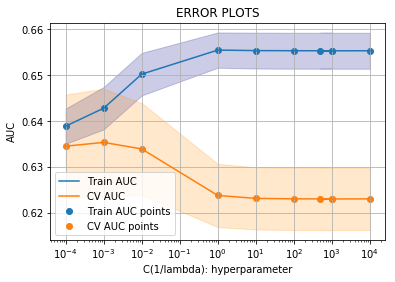

In [79]:

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

clf = LogisticRegression(class_weight='balanced');
parameters ={'C':[10**-4, 10**-3,10**-2,1,10,100,1000,500,1000,10000]}
cl = GridSearchCV(clf, parameters, cv=3, scoring='roc_auc',return_train_score=True)
cl.fit(X_set5_train, y_train);

train_auc= cl.cv_results_['mean_train_score']
train_auc_std= cl.cv_results_['std_train_score']
cv_auc = cl.cv_results_['mean_test_score'] 
cv_auc_std= cl.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
plt.xscale('log') 

plt.legend()
plt.xlabel("C(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

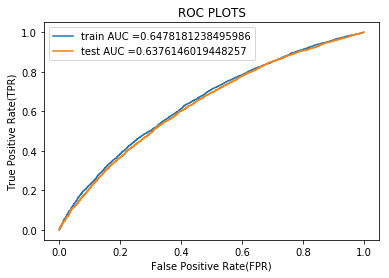

In [80]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
neigh = LogisticRegression(C=10**-2,class_weight='balanced');
neigh.fit(X_set5_train ,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_set5_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_set5_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

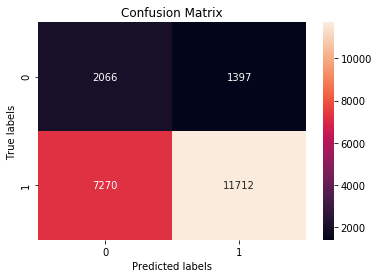

In [81]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, neigh.predict(X_set5_train)), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

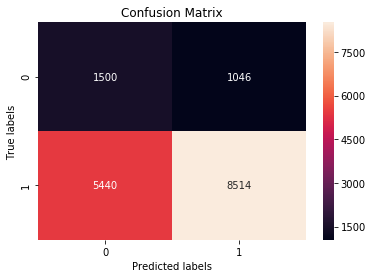

In [82]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, neigh.predict(X_set5_test )), annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Conclusion : 
1. If we compare the roc curves between model with Text features and model without the text features , the model with the text features included is better as the auc and the Confusion metrix gives better results .

In [83]:
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

tb = PrettyTable()
tb.field_names= ("Vectorizer", "HyperParameter", "AUC")
tb.add_row(["BOW",10**-3, 70])
tb.add_row(["Tf-Idf",1, 66])
tb.add_row(["AVGW2V",1, 69])
tb.add_row(["Tf-Idf w2v", 10**-2, 60])
tb.add_row(["Set 5",10**-3, 64])
print(tb.get_string(titles = "Logistic Reg> - Observations"))

+------------+----------------+-----+
| Vectorizer | HyperParameter | AUC |
+------------+----------------+-----+
|    BOW     |     0.001      |  70 |
|   Tf-Idf   |       1        |  66 |
|   AVGW2V   |       1        |  69 |
| Tf-Idf w2v |      0.01      |  60 |
|   Set 5    |     0.001      |  64 |
+------------+----------------+-----+
